In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
from matplotlib.markers import MarkerStyle
from matplotlib.path import Path
from scipy.stats import zscore
from scipy.signal import savgol_filter

import anndata as an
import scanpy as sc
import rapids_singlecell as rsc

import rmm
import cupy
import cudf
import cupy as cp
from rmm.allocators.cupy import rmm_cupy_allocator

# Enable `managed_memory`
rmm.reinitialize(
    managed_memory=True,
    pool_allocator=False,
)
cp.cuda.set_allocator(rmm_cupy_allocator)

/nfs/turbo/umms-indikar/Cooper/conda_envs/rapids/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
%%time
dpath = "/scratch/indikar_root/indikar1/shared_data/hybrid_segmentation/regionprops/"
file_list = glob.glob(f"{dpath}*_*_*.csv") # exclude the test image

df_list = []

for fpath in file_list:
    basename = os.path.basename(fpath).replace(".csv", "")
    stage, condition, scene, _ = basename.split("_")
    
    df = pd.read_csv(fpath)
    df['basename'] = basename
    df['stage'] = int(stage)
    df['condition'] = condition
    df['scene'] = scene
    
    print(f"\t{basename} {df.shape=}")

    df_list.append(df)


df = pd.concat(df_list)
print(f"{df.shape=}")
df.head()

	02_siPRRX1_B3_props df.shape=(188240, 49)
	01_mmMYOD1_D4_props df.shape=(35964, 49)
	01_control_D2_props df.shape=(31271, 49)
	01_hybrid_C3_props df.shape=(49123, 49)
	01_mmMYOD1_D3_props df.shape=(33663, 49)
	02_hybrid_C6_props df.shape=(123894, 49)
	02_hybrid_C4_props df.shape=(145648, 49)
	01_hybrid_C4_props df.shape=(64240, 49)
	02_mmMYOD1_D4_props df.shape=(72217, 49)
	02_siPRRX1_B4_props df.shape=(198826, 49)
	02_hybrid_C3_props df.shape=(133759, 49)
	01_hybrid_C6_props df.shape=(57297, 49)
	01_control_C2_props df.shape=(39967, 49)
	02_mmMYOD1_D3_props df.shape=(68484, 49)
	01_siPRRX1_B4_props df.shape=(80394, 49)
	02_control_C2_props df.shape=(94187, 49)
	01_siPRRX1_B3_props df.shape=(70595, 49)
	01_control_B2_props df.shape=(40213, 49)
	02_control_D2_props df.shape=(65965, 49)
	02_control_B2_props df.shape=(91039, 49)
df.shape=(1684986, 49)
CPU times: user 8.56 s, sys: 882 ms, total: 9.45 s
Wall time: 17.4 s


label   area  bbox-0  bbox-1  bbox-2  bbox-3  bbox_area   centroid-0  \
0      1  139.0     770     366     786     378      192.0   777.402878   
1      2   92.0     513    2953     524    2964      121.0   517.945652   
2      3  131.0    2553     722    2566     735      169.0  2558.908397   
3      4  638.0    2205    1117    2234    1148      899.0  2219.070533   
4      5  146.0     702     806     719     818      204.0   710.260274   

    centroid-1  eccentricity  ...  mKate_max  mKate_min   mKate_sum  time  \
0   371.733813      0.787459  ...   0.211949   0.101667   29.239852     0   
1  2957.891304      0.204520  ...   0.211949   0.003333   11.038021     0   
2   727.664122      0.528127  ...   0.211949   0.005833   16.582590     0   
3  1131.733542      0.746750  ...   0.211949   0.211949  135.223725     0   
4   811.657534      0.793181  ...   0.211949   0.127783   30.855447     0   

   seg_channel_idx  seg_channel_name             basename  stage  condition  \
0                2               Cy5  02_siPRRX1_B3_props      2    siPRRX1   
1                2               Cy5  02_siPRRX1_B3_props      2    siPRRX1   
2                2               Cy5  02_siPRRX1_B3_props      2    siPRRX1   
3                2               Cy5  02_siPRRX1_B3_props      2    siPRRX1   
4                2               Cy5  02_siPRRX1_B3_props      2    siPRRX1   

   scene  
0     B3  
1     B3  
2     B3  
3     B3  
4     B3  

[5 rows x 49 columns]

# Predict phase simple

<timed exec>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<timed exec>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


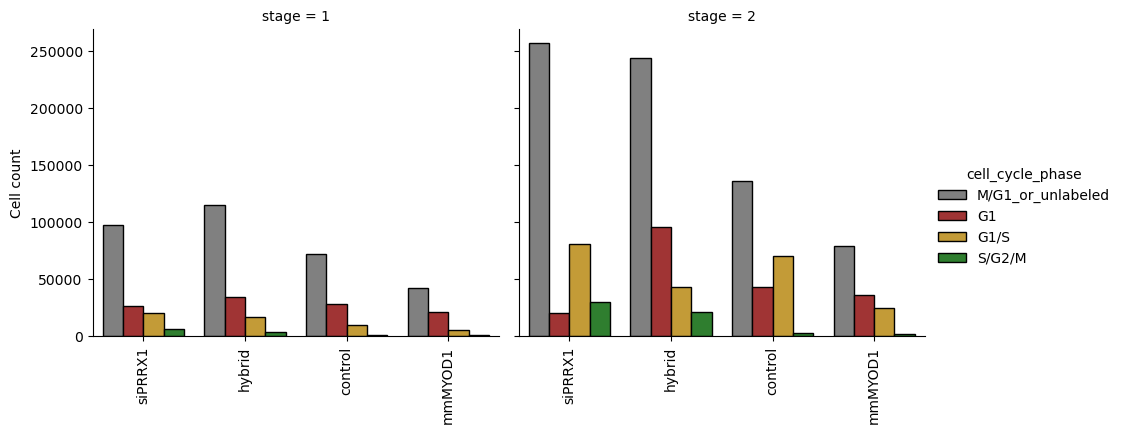

CPU times: user 10.4 s, sys: 1.47 s, total: 11.9 s
Wall time: 11.9 s


In [3]:
%%time

df['TaGFP_norm'] = (df['TaGFP_mean'] - df['TaGFP_mean'].min()) / (df['TaGFP_mean'].max() - df['TaGFP_mean'].min())
df['mKate_norm'] = (df['mKate_mean'] - df['mKate_mean'].min()) / (df['mKate_mean'].max() - df['mKate_mean'].min())

def classify_cell(row, th_low=0.2, th_high=0.5):
    g, r = row['TaGFP_norm'], row['mKate_norm']

    if r > th_high and g < th_low:
        return "G1"
    elif g > th_high and r < th_low:
        return "S/G2/M"
    elif g > th_high and r > th_high:
        return "G1/S"
    else:
        return "M/G1_or_unlabeled"

df['cell_cycle_phase'] = df.apply(classify_cell, axis=1)

# aggregate
phase = (
    df[['cell_cycle_phase', 'condition', 'stage']]
    .value_counts()
    .reset_index(name='count')
)

# facet by stage
g = sns.catplot(
    data=phase,
    x='condition',
    y='count',
    hue='cell_cycle_phase',
    col='stage',
    kind='bar',
    palette=['grey', 'firebrick', 'goldenrod', 'forestgreen'],
    ec='k',
    height=4,
    aspect=1.2
)

# tidy up each panel
g.set_axis_labels("", "Cell count")
for i, ax in enumerate(g.axes.flat):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine()

plt.show()

In [4]:
df.head()

label   area  bbox-0  bbox-1  bbox-2  bbox-3  bbox_area   centroid-0  \
0      1  139.0     770     366     786     378      192.0   777.402878   
1      2   92.0     513    2953     524    2964      121.0   517.945652   
2      3  131.0    2553     722    2566     735      169.0  2558.908397   
3      4  638.0    2205    1117    2234    1148      899.0  2219.070533   
4      5  146.0     702     806     719     818      204.0   710.260274   

    centroid-1  eccentricity  ...  time  seg_channel_idx  seg_channel_name  \
0   371.733813      0.787459  ...     0                2               Cy5   
1  2957.891304      0.204520  ...     0                2               Cy5   
2   727.664122      0.528127  ...     0                2               Cy5   
3  1131.733542      0.746750  ...     0                2               Cy5   
4   811.657534      0.793181  ...     0                2               Cy5   

              basename  stage  condition  scene  TaGFP_norm  mKate_norm  \
0  02_siPRRX1_B3_props      2    siPRRX1     B3    1.000000    0.992427   
1  02_siPRRX1_B3_props      2    siPRRX1     B3    0.931658    0.562159   
2  02_siPRRX1_B3_props      2    siPRRX1     B3    0.963576    0.593609   
3  02_siPRRX1_B3_props      2    siPRRX1     B3    0.993330    1.000000   
4  02_siPRRX1_B3_props      2    siPRRX1     B3    0.995063    0.997093   

   cell_cycle_phase  
0              G1/S  
1              G1/S  
2              G1/S  
3              G1/S  
4              G1/S  

[5 rows x 52 columns]

# Convert to Adata

In [5]:
%%time 
# --- your feature list (vars) ---
VARS = [
    'area','bbox_area',
    'eccentricity','equivalent_diameter',
    'euler_number','feret_diameter_max','filled_area',
    'inertia_tensor_eigvals-0','inertia_tensor_eigvals-1',
    'major_axis_length','minor_axis_length','orientation',
    'perimeter','perimeter_crofton', 'solidity','Cy5_mean',
    'Cy5_max','Cy5_min', 'Cy5_sum',
    'TaGFP_mean','TaGFP_max','TaGFP_min','TaGFP_sum',
    'mKate_mean','mKate_max','mKate_min','mKate_sum','time',
    'TaGFP_norm','mKate_norm',
]

# --- obs: all metadata, with a new unique index ---
obs = df.copy()
obs.index = [f"cell_{i}" for i in range(len(obs))]  # new unique ID
obs = obs.drop(columns=VARS)
print(f"{obs.shape=}")

# --- X: selected numeric features ---
X_df = df[VARS].copy()

encodings = {}
for col in X_df.columns:
    if not np.issubdtype(X_df[col].dtype, np.number):
        print(f"OOPS! {col} not numeric...")
        codes, cats = pd.factorize(X_df[col].astype('string'), sort=True)
        encodings[col] = list(cats.astype(str))
        X_df[col] = codes.astype(float)

# --- var metadata ---
var = pd.DataFrame(index=X_df.columns)
var['dtype'] = [str(X_df[c].dtype) for c in X_df.columns]
var['encoded'] = var.index.isin(encodings).astype(bool)

# --- build AnnData ---
adata = an.AnnData(
    X=X_df.to_numpy(dtype=float),
    obs=obs,
    var=var
)
adata.obs_names_make_unique()
if encodings:
    adata.uns['factor_levels'] = encodings

adata

obs.shape=(1684986, 22)
CPU times: user 1.54 s, sys: 1.68 s, total: 3.22 s
Wall time: 3.23 s


AnnData object with n_obs × n_vars = 1684986 × 30
    obs: 'label', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'centroid-0', 'centroid-1', 'extent', 'local_centroid-0', 'local_centroid-1', 'centroid_x_px', 'centroid_y_px', 'centroid_x_um', 'centroid_y_um', 'centroid_unit', 'seg_channel_idx', 'seg_channel_name', 'basename', 'stage', 'condition', 'scene', 'cell_cycle_phase'
    var: 'dtype', 'encoded'

# Clustering

In [6]:
%%time
# sample fraction of cells
fraction = 0.05
bdata = adata.copy()
sc.pp.subsample(bdata, fraction=fraction)
bdata

CPU times: user 547 ms, sys: 274 ms, total: 821 ms
Wall time: 823 ms


AnnData object with n_obs × n_vars = 84249 × 30
    obs: 'label', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'centroid-0', 'centroid-1', 'extent', 'local_centroid-0', 'local_centroid-1', 'centroid_x_px', 'centroid_y_px', 'centroid_x_um', 'centroid_y_um', 'centroid_unit', 'seg_channel_idx', 'seg_channel_name', 'basename', 'stage', 'condition', 'scene', 'cell_cycle_phase'
    var: 'dtype', 'encoded'

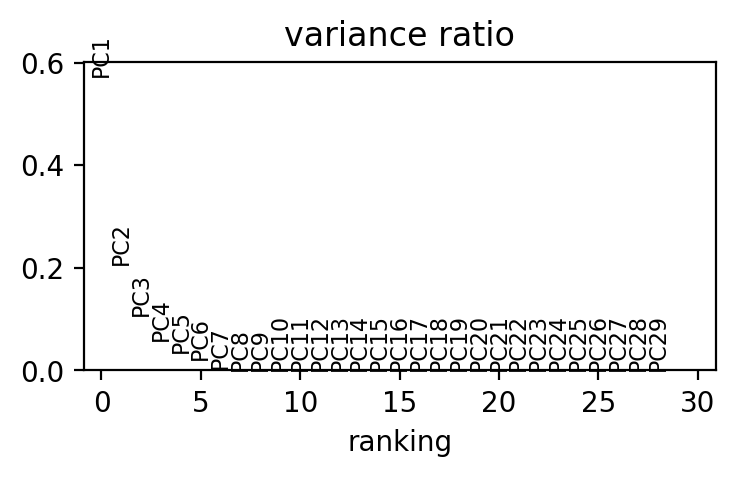

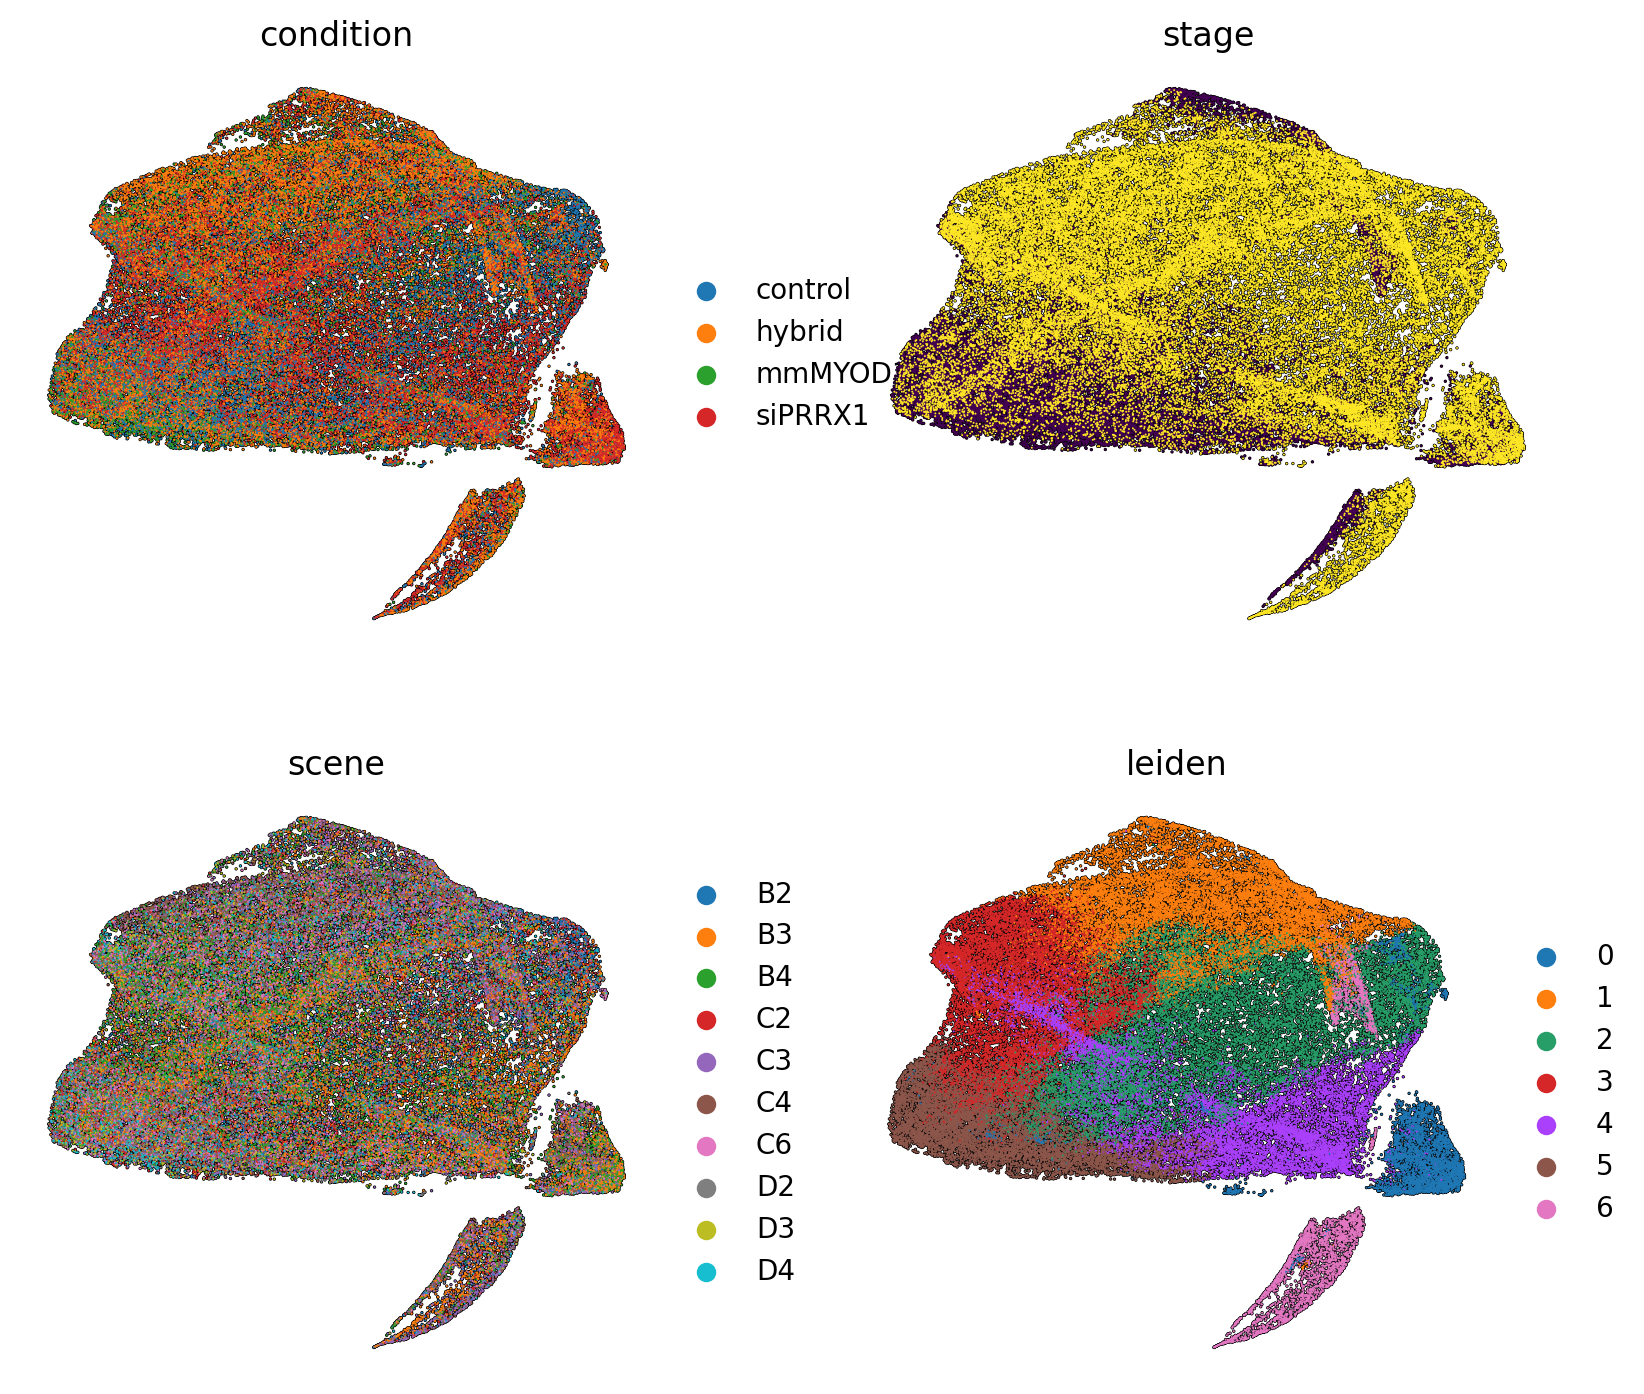

CPU times: user 6.37 s, sys: 252 ms, total: 6.62 s
Wall time: 6.64 s


In [30]:
%%time 
rsc.get.anndata_to_GPU(bdata)
rsc.pp.normalize_total(bdata, target_sum=1e3)
rsc.tl.pca(bdata)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
sc.pl.pca_variance_ratio(bdata)

rsc.pp.neighbors(bdata, n_neighbors=15)
rsc.tl.leiden(bdata, resolution=0.2)
rsc.tl.umap(bdata, min_dist=0.2)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.umap(
    bdata,
    ncols=2,
    color=["condition", "stage", "scene",'leiden'],
    size=2,
    add_outline=True,
    outline_color=('k', 'k'),
    alpha=1,
    frameon=False,
    colorbar_loc=None,
)


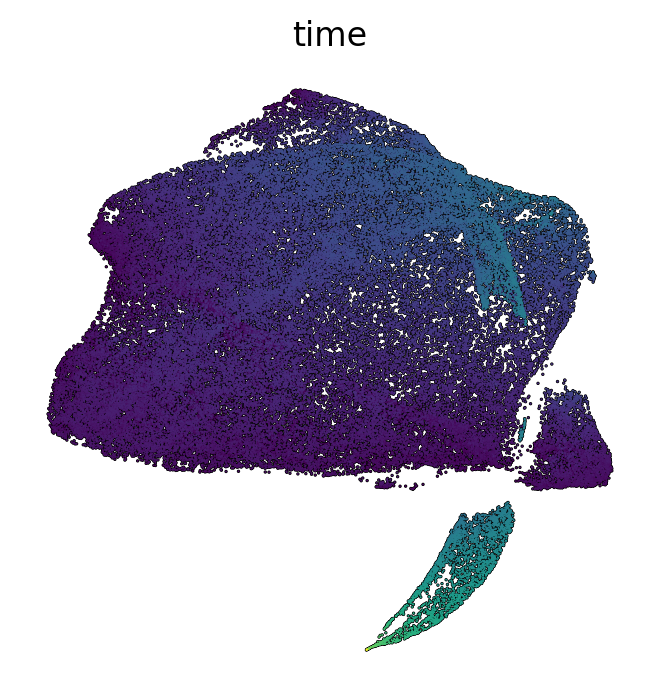

In [32]:
rsc.get.anndata_to_CPU(bdata)

sc.pl.umap(
    bdata,
    ncols=2,
    color=["time"],
    size=2,
    add_outline=True,
    outline_color=('k', 'k'),
    alpha=1,
    frameon=False,
    colorbar_loc=None,
)

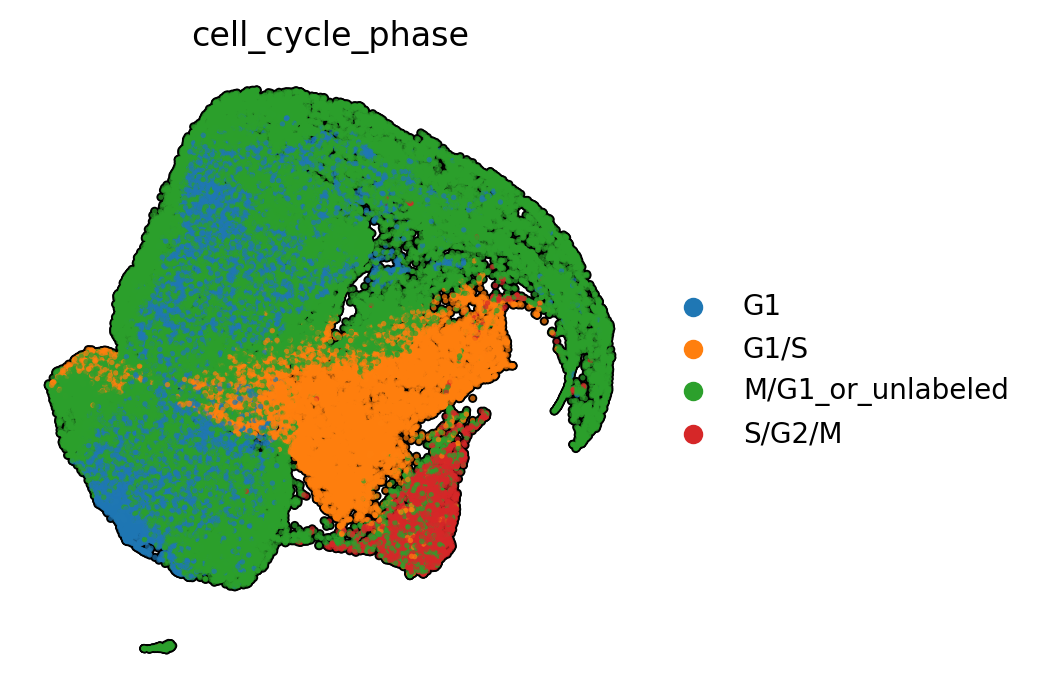

In [17]:
rsc.get.anndata_to_CPU(bdata)

sc.pl.umap(
    bdata,
    sort_order=True,
    ncols=2,
    color=['cell_cycle_phase'],
    size=15,
    add_outline=True,
    outline_color=('k', 'k'),
    vmin=0,
    frameon=False,
    colorbar_loc=None,
)

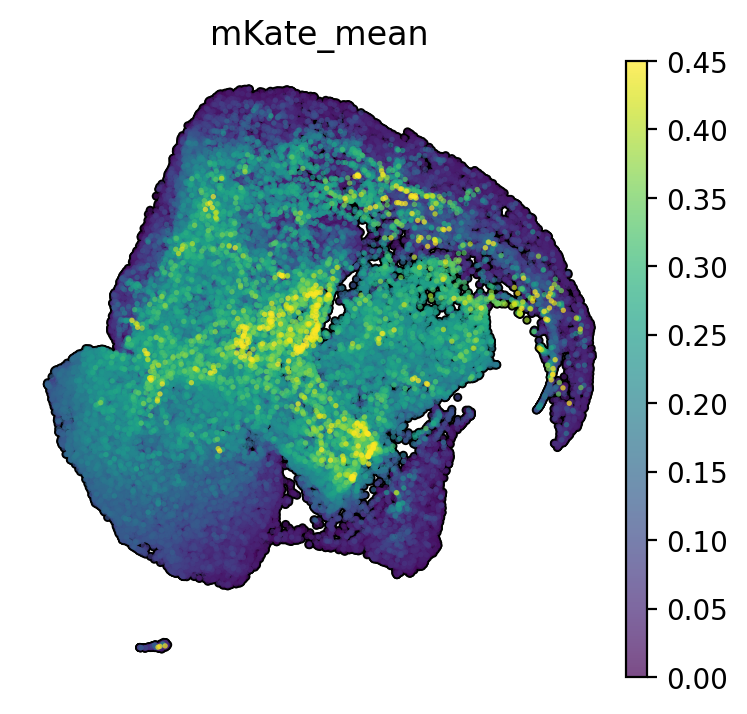

In [29]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4.25, 4

sc.pl.umap(
    bdata,
    sort_order=True,
    ncols=2,
    color=['mKate_mean'],
    size=15,
    add_outline=True,
    outline_color=('k', 'k'),
    vmin=0,
    vmax=0.45,
    frameon=False,
)

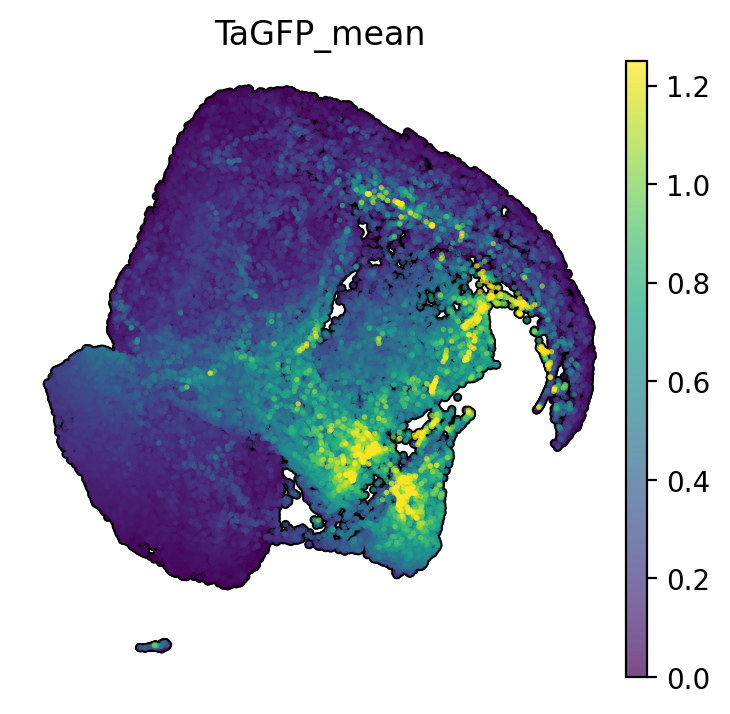

In [28]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4.25, 4

sc.pl.umap(
    bdata,
    sort_order=True,
    ncols=2,
    color=['TaGFP_mean'],
    size=15,
    add_outline=True,
    outline_color=('k', 'k'),
    vmin=0,
    vmax=1.25,
    frameon=False,
)